In [2]:
import requests
import re
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import nltk
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


In [4]:
beer_train = pd.read_csv('beer_train.csv')

In [64]:
hop_list = pd.read_csv('hop_list.csv')

In [6]:
malt_list = pd.read_csv('malt_list.csv')

In [7]:
char_list = pd.read_csv('char_list.csv')

In [300]:
#need to get rid of country in () do a .split
hop_list.shape

(148, 16)

In [10]:
malt_list.head()

Unnamed: 0  malt_coarseFineDifference  malt_country_code  \
0           0                        NaN                NaN   
1           1                        1.5                NaN   
2           2                        1.3                NaN   
3           3                        NaN                NaN   
4           4                        2.0                NaN   

                                    malt_description  malt_dryYield  malt_id  \
0                                                NaN            NaN   1947.0   
1  A dark malt that gives a rich red or brown col...           60.0    429.0   
2  Munich Malt has a malty sweet flavor character...           80.0    650.0   
3                                                NaN            NaN    536.0   
4  This Canadian malt imparts a honey-like flavor...           80.0    589.0   

   malt_maxInBatch  malt_moistureContent        malt_name  malt_potential  \
0              NaN                   NaN  Barley - Malted             NaN   
1             10.0                   4.0   Chocolate Malt           1.028   
2             80.0                   5.0      Munich Malt           1.037   
3              NaN                   NaN    Oats - Flaked             NaN   
4             10.0                   3.8       Honey Malt           1.037   

   malt_protien  malt_srmPrecise  
0           NaN              NaN  
1           NaN            350.0  
2           NaN              9.0  
3           NaN              NaN  
4           NaN             25.0

In [11]:
char_list.head()


Unnamed: 0                           malt_char_description  malt_char_id  \
0           0      Imparts a chocolate quality upon the beer.           6.0   
1           1           Imparts a malty flavor upon the beer.          10.0   
2           2           Imparts a malty flavor upon the beer.          10.0   
3           3           Imparts a malty flavor upon the beer.          10.0   
4           8  Imparts a burnt tasting quality upon the beer.           4.0   

  malt_char_name  malt_id         malt_name  
0      Chocolate    429.0    Chocolate Malt  
1          Malty    650.0       Munich Malt  
2          Malty    589.0        Honey Malt  
3          Malty    234.0         Pale Malt  
4          Burnt    753.0  Barley - Roasted

In [7]:
beer_train.rename(columns = {'id':'beer_id'}, inplace = True)

In [8]:
beer_train.shape

(19553, 16)

In [64]:
r = requests.get('http://api.brewerydb.com/v2/beers/?key=209db383ed1d39ec3aa1c13f89161c25&p=1&withBreweries=Y&withIngredients=Y')
d= r.json()
d 

{u'currentPage': 1,
 u'data': [{u'abv': u'11.1',
   u'breweries': [{u'createDate': u'2013-01-20 21:32:30',
     u'description': u'Our humble beginnings started in the Summer of 1995 in Ship Bottom, NJ. Back then we made our first batch of beer using a home brew kit that consisted of a plastic bucket, large spoon, bottling bucket and some bottle caps. We hardly knew what what would be ahead of us 16 years later! We learned a lot over the last 16 years and feel that we really refined our craft. We are a small (Nano) brewer...See More',
     u'established': u'2011',
     u'id': u'qa1QZU',
     u'images': {u'icon': u'https://s3.amazonaws.com/brewerydbapi/brewery/qa1QZU/upload_ZwdBjC-icon.png',
      u'large': u'https://s3.amazonaws.com/brewerydbapi/brewery/qa1QZU/upload_ZwdBjC-large.png',
      u'medium': u'https://s3.amazonaws.com/brewerydbapi/brewery/qa1QZU/upload_ZwdBjC-medium.png',
      u'squareLarge': u'https://s3.amazonaws.com/brewerydbapi/brewery/qa1QZU/upload_ZwdBjC-squareLarge.pn

In [84]:
beer_id = list(beer_train['beer_id'])

if '7xU7NH' in beer_id:
    print 'yes'

yes


In [85]:
#for index, row in beer_train[:5].iterrows():
for n in range(4,1183):
    print n
    #print beer_train[beer_train['beer_id'] == row['beer_id']].index[0] 
    r = requests.get('http://api.brewerydb.com/v2/beers/?key=209db383ed1d39ec3aa1c13f89161c25&p='+str(n)+'&withBreweries=Y&withIngredients=Y')
    data = r.json().get('data')
    for m in range(0,len(data)):
        d = data[m]
        breweries = d.get('breweries', [{}])
        brewery = breweries[0]
        locations = brewery.get('locations', [{}])
        location = locations[0]  
        if d.get('id') in beer_id:                   
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'brewery_id'] = brewery.get('id')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'brewery_name'] = brewery.get('name')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'brewery_description'] = brewery.get('description')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'brewery_established'] = brewery.get('established')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'brewery_locality'] = location.get('locality')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'loc_country_code'] = location.get('country', {}).get('numberCode')
            beer_train.loc[beer_train[beer_train['beer_id'] == str(d.get('id'))].index[0], 'loc_country_name'] = location.get('country', {}).get('name')


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [11]:
beer_train.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1  \
0           0             0             0               0               0   
1           1             1             1               1               1   
2           2             2             2               2               2   
3           3             3             3               3               3   
4           4             4             4               4               4   

  beer_id                      name       abv  ibu  originalGravity  \
0  njehqH                   144 IPA  5.989875    0         1.060000   
1  EVVV1r          1488 Whisky Beer  7.000000    0         1.040747   
2  295GZo      19 Original Colonies  5.500000    0         1.008000   
3  Np1soi  666 Premium British Beer  6.600000    0         1.048345   
4  7xU7NH             Ace of Simcoe  4.500000    0         1.035323   

                      ...                     loc_country_name  hop_alphaacid  \
0                     ...                                  NaN            NaN   
1                     ...                       UNITED KINGDOM            NaN   
2                     ...                        UNITED STATES            NaN   
3                     ...                       UNITED KINGDOM            NaN   
4                     ...                       UNITED KINGDOM           16.5   

   hop_betaacid hop_caryophyllene hop_myrcene hop_humulene  hop_cohumulone  \
0           NaN               NaN         NaN          NaN             NaN   
1           NaN               NaN         NaN          NaN             NaN   
2           NaN               NaN         NaN          NaN             NaN   
3           NaN               NaN         NaN          NaN             NaN   
4         4.125               9.0       51.25         13.5           25.25   

  hop_geraniol hop_totaloil                              full_beer_name  
0          NaN          NaN                                     144 IPA  
1          NaN          NaN         Black Wolf Brewery 1488 Whisky Beer  
2          NaN          NaN             Rogue Ales 19 Original Colonies  
3          NaN          NaN  Robinsons Brewery 666 Premium British Beer  
4          0.8         2.45                       BrewDog Ace of Simcoe  

[5 rows x 34 columns]

In [7]:
for index, row in beer_train.iterrows():
    if row['brewery_name'] > 0:
        beer_train.loc[index, 'full_beer_name'] = row['brewery_name'] +' '+ row['name']
    else:
        beer_train.loc[index, 'full_beer_name'] = row['name']

In [8]:
reg_tag = re.compile("/beer/profile/\d+/\d+/")

def get_url_from_beer_name(name):
    urls = []
    r= requests.get('https://www.beeradvocate.com/search/?q='+name.lower()+'&qt=beer')
    b = BeautifulSoup(r.text, 'html.parser')
    a_tag = b.findAll('a' , attrs={'href': reg_tag})
    for link in a_tag:
        urls.append(link.get('href'))
    if urls:
        return urls[0]
    return None

In [9]:
def get_desc_from_advocate(url):
    r= requests.get('https://www.beeradvocate.com'+url)
    b = BeautifulSoup(r.text, 'html.parser')
    brs = b.findAll('br')
    for index, be in enumerate(brs):
        if 'notes' in be.text.lower():
            return brs[index+1].text.split('Notes / Commercial Description:')[1].strip()

In [10]:
def get_desc_from_beer_name(name):
    url = get_url_from_beer_name(name)
    if url:
        return get_desc_from_advocate(url)
    else:
        return None

In [11]:
done = 0
for index, row in beer_train[2800:].iterrows():
    if not row['beer_description'] > 0 and row['full_beer_name']:
        beer_train.loc[index, 'beer_description'] = get_desc_from_beer_name(row['full_beer_name'])
        done += 1
    if done % 20 == 0:
        print done

0
0
0
20
20
20
20
40
40
40
40
40
40
40
40
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
80
80
80
100
100
100
100
100
100
100
100
100
100
100
120
120
120
120
120
120
120
120
120
120
120
120
140
140
140
140
140
140
140
140
160
160
160
160
160
160
160
160
160
160
160
180
200
200
200
220
220
220
220
220
220
240
240
240
240
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
280
280
280
280
300
300
300
300
300
300
300
300
300
300
300
300
300
320
320
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
400
400
400
400
400
400
400
400
400
420
440
440
440
440
440
440
440
440
440
440
440
440
460
460
46

In [12]:
beer_train.isnull().sum()

Unnamed: 0                 0
Unnamed: 0.1               0
Unnamed: 0.1               0
Unnamed: 0.1.1             0
Unnamed: 0.1.1             0
beer_id                    0
name                       0
abv                       17
ibu                        0
originalGravity           16
isOrganic                  0
categoryId                 0
styleId                    0
style_name                 0
style_description          0
beer_description        1754
srmId                     16
duplicate                  0
brewery_id               152
brewery_name             152
brewery_description     1657
brewery_established     3043
brewery_locality         349
loc_country_code         162
loc_country_name         162
hop_alphaacid          10764
hop_betaacid           10764
hop_caryophyllene      10764
hop_myrcene            10764
hop_humulene           10764
hop_cohumulone         10764
hop_geraniol           10764
hop_totaloil           10764
full_beer_name             0
dtype: int64

In [13]:
def f(x):
    if x and type(x) is not float:
        if 'No notes at thi' in x:
            return None
        
        return x.split('Added')[0]

In [14]:
beer_train['beer_description'] = beer_train['beer_description'].apply(f)

In [8]:
beer_train.isnull().sum()

Unnamed: 0                 0
Unnamed: 0.1               0
Unnamed: 0.1               0
Unnamed: 0.1.1             0
Unnamed: 0.1.1             0
Unnamed: 0.1.1.1           0
beer_id                    0
name                       0
abv                       17
ibu                        0
originalGravity           16
isOrganic                  0
categoryId                 0
styleId                    0
style_name                 0
style_description          0
beer_description        2742
srmId                     16
duplicate                  0
brewery_id               152
brewery_name             152
brewery_description     1657
brewery_established     3043
brewery_locality         349
loc_country_code         162
loc_country_name         162
hop_alphaacid          10764
hop_betaacid           10764
hop_caryophyllene      10764
hop_myrcene            10764
hop_humulene           10764
hop_cohumulone         10764
hop_geraniol           10764
hop_totaloil           10764
full_beer_name

In [16]:
beer_train.to_csv('beer_train.csv', encoding = 'utf-8')

In [390]:
# check duplicate listings
pd.set_option('display.max_rows', 200)
hop_list[hop_list['hop_name'] == Fuggles.apply(lambda x:x.split(' (American)')[0])
hop_list['hop_name'].value_counts().sort_index()


Admiral                               1
Ahtanum                               1
Amarillo                              1
Amarillo Gold                         1
Aramis                                1
Aurora                                1
Bobek                                 1
Bramling Cross                        1
Bravo                                 1
Cascade                               1
Celeia                                1
Centennial                            1
Challenger                            1
Chinook                               1
Citra                                 1
Cluster                               1
Columbus                              1
Columbus Tomahawk                     1
Comet                                 1
Crystal                               1
East Kent Golding                     1
El Dorado                             1
Ella                                  1
First Gold                            1
Fuggle (American)                     1


In [234]:
r = requests.get('https://ychhops.com/varieties?q=perle')
b = BeautifulSoup(r.text, 'html.parser')
b

\n<!DOCTYPE html>\n\n<html lang="en-US" xmlns="https://www.w3.org/1999/xhtml">\n<head>\n<meta charset="unicode-escape"/>\n<title>Varieties - YCH HOPS</title>\n<meta content="width=device-width,minimum-scale=1,initial-scale=1" name="viewport"/>\n<meta content="gdi" http-equiv="X-UA-TextLayoutMetrics"/>\n<link href="https://ychhops.com/" rel="home"/>\n<link href="https://ychhops.com/favicon.ico" rel="shortcut icon"/>\n<link href="https://ychhops.com/favicon.ico" rel="icon" type="image/x-icon"/>\n<link href="https://ychhops.com/assets/img/apple-touch-icon.png" rel="apple-touch-icon">\n<link href="https://ychhops.com/assets/img/apple-touch-icon.png" rel="icon" sizes="192x192">\n<link href="https://fonts.googleapis.com/css?family=Roboto:400,500,700,500italic,700italic,900,900italic,400italic|Yanone+Kaffeesatz:400,700|Exo+2:400,700,800,700italic,800italic,400italic,500,500italic|Oswald:400,700" rel="stylesheet" type="text/css">\n<link href="/assets/css/bundle.css" rel="stylesheet"/>\n<meta c

In [235]:
b.findAll('a')

[<a class="masthead__logo" href="/" itemprop="url">\n<img alt="YCH Hops Logo" itemprop="logo" src="/assets/img/ych-logo-icon.svg">\n</img></a>,
 <a href="https://www.facebook.com/YCHHOPS" itemprop="sameAs" target="_Blank">\n<i class="fa fa-facebook-square facebook"></i>\n</a>,
 <a href="https://twitter.com/YCHHOPS" itemprop="sameAs" target="_Blank">\n<i class="fa fa-twitter-square twitter"></i>\n</a>,
 <a href="https://www.youtube.com/user/HopunionHops" itemprop="sameAs" target="_Blank">\n<i class="fa fa-youtube-square youtube"></i>\n</a>,
 <a href="https://www.instagram.com/ychhops" itemprop="sameAs" target="_Blank">\n<i class="fa fa-instagram instagram"></i>\n</a>,
 <a href="https://plus.google.com/+YCHHopsOfficial" itemprop="sameAs" target="_Blank">\n<i class="fa fa-google-plus-square google-plus"></i>\n</a>,
 <a href="/connect/news/blog">\n<span>Blog</span>\n</a>,
 <a href="/connect/contact-us">\n<span>Contact</span>\n</a>,
 <a href="/varieties" itemprop="name url">Hop Varieties</a

In [236]:
url_tag = re.compile("card__name")
def get_url_from_hop_name(name):
    urls = []
    r= requests.get('https://ychhops.com/varieties?q='+name.lower().split(' ')[0])
    b = BeautifulSoup(r.text, 'html.parser')
    u_tag = b.findAll('a' , attrs={'class': url_tag})
    for link in u_tag:
        urls.append(link.get('href'))
    if urls:
        for n in range(0,len(urls)):
            if name.lower().split(' ')[0] in urls[n]:
                return urls[n]
    return None


print get_url_from_hop_name('perle')


https://ychhops.com/varieties/perle


In [332]:
reg_tag = re.compile("hop-composition__item")
reg_tag2 = re.compile("hop-composition__value")

def get_chars(url, name):
    r= requests.get(url)
    b = BeautifulSoup(r.text, 'html.parser')
    char_name = b.findAll('div', attrs = {'class': reg_tag})
    num = b.findAll('div', attrs = {'class': reg_tag2})
    hop_dict = {}
    for n in range(0,len(char_name)):
        hop_dict[str(char_name[n].text)+'_min'] = num[n].text.split(' -')[0]
        if len(num[n].text.split(' -')) > 1:
            hop_dict[str(char_name[n].text)+'_max'] = num[n].text.split(' -')[1].split('%')[0].strip()
        else:
            hop_dict[str(char_name[n].text)+'_max'] = None
    return hop_dict

       


In [333]:
words = '6 - 9%'
print len(words.split(' -'))
          #[0].split('< ')[1].split('%')[0]

2


In [334]:
def get_char_from_name(name):
    url = get_url_from_hop_name(name)
    if url:
        return get_chars(url, name)
    else:
        return None
print get_char_from_name('perle')

{'Humulene_min': u'28', 'Geraniol_max': u'0.4', 'B-Pinene_min': u'0.3', 'B-Pinene_max': u'0.6', 'Humulene_max': u'34', 'Myrcene_min': u'30', 'Total Oil_max': u'2 mL/100g', 'Co-humulone_max': u'31', 'Caryophyllene_max': u'16', 'Farnesene_max': None, 'Caryophyllene_min': u'12', 'Alpha Acid_min': u'6', 'Beta Acid_max': u'4.5', 'Beta Acid_min': u'3', 'Farnesene_min': u'< 1.0% of total oil', 'Co-humulone_min': u'28', 'Total Oil_min': u'0.8', 'Myrcene_max': u'45', 'Alpha Acid_max': u'9', 'Geraniol_min': u'0.2', 'Linalool_max': u'0.8', 'Linalool_min': u'0.3'}


In [335]:
hops_dict = {}
for index, row in hop_list.iterrows():
    print row['hop_name'].index
    hops_dict[row['hop_name']] = get_char_from_name(row['hop_name'])

<built-in method index of str object at 0x000000000D945AE8>
<built-in method index of str object at 0x000000000D604A20>
<built-in method index of str object at 0x000000000D50CB20>
<built-in method index of str object at 0x000000000D604AB0>
<built-in method index of str object at 0x000000000D50CB48>
<built-in method index of str object at 0x000000000D604AE0>
<built-in method index of str object at 0x000000000D604B10>
<built-in method index of str object at 0x000000000D50CB70>
<built-in method index of str object at 0x000000000D50CB98>
<built-in method index of str object at 0x000000000D50CBC0>
<built-in method index of str object at 0x000000000D945B20>
<built-in method index of str object at 0x000000000D945B58>
<built-in method index of str object at 0x000000000D945B90>
<built-in method index of str object at 0x000000000D604B40>
<built-in method index of str object at 0x000000000D604B70>
<built-in method index of str object at 0x000000000D50CBE8>
<built-in method index of str object at 

In [336]:
hops_dict

{'#06300': None,
 'Admiral': {'Alpha Acid_max': u'16',
  'Alpha Acid_min': u'13',
  'Beta Acid_max': u'6',
  'Beta Acid_min': u'4',
  'Caryophyllene_max': u'8',
  'Caryophyllene_min': u'6',
  'Co-humulone_max': u'45',
  'Co-humulone_min': u'37',
  'Farnesene_max': u'2',
  'Farnesene_min': u'0',
  'Geraniol_max': u'0',
  'Geraniol_min': u'0',
  'Humulene_max': u'26',
  'Humulene_min': u'23',
  'Myrcene_max': u'48',
  'Myrcene_min': u'39',
  'Total Oil_max': u'1.7 mL/100g',
  'Total Oil_min': u'1'},
 'Aged / Debittered Hops (Lambic)': None,
 'Ahtanum': {'Alpha Acid_max': u'6.5',
  'Alpha Acid_min': u'3.5',
  'B-Pinene_max': u'0.9',
  'B-Pinene_min': u'0.6',
  'Beta Acid_max': u'6',
  'Beta Acid_min': u'4',
  'Caryophyllene_max': u'12',
  'Caryophyllene_min': u'9',
  'Co-humulone_max': u'34',
  'Co-humulone_min': u'30',
  'Farnesene_max': None,
  'Farnesene_min': u'< 1.0% of total oil',
  'Geraniol_max': u'0.7',
  'Geraniol_min': u'0.4',
  'Humulene_max': u'22',
  'Humulene_min': u'15',
 

In [343]:
for index,row in hop_list.iterrows():
    print row['hop_name']
    if hops_dict[row['hop_name']] > 0:
        if 'Alpha Acid_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Alpha Acid_max'] = hops_dict[row['hop_name']]['Alpha Acid_max']
        if 'Alpha Acid_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Alpha Acid_min'] = hops_dict[row['hop_name']]['Alpha Acid_max']
        if 'Beta Acid_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Beta Acid_max'] = hops_dict[row['hop_name']]['Beta Acid_max']
        if 'Beta Acid_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Beta Acid_min'] = hops_dict[row['hop_name']]['Beta Acid_min']
        if 'Caryophyllene_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Caryophyllene_max'] = hops_dict[row['hop_name']]['Caryophyllene_max']
        if 'Caryophyllene_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Caryophyllene_min'] = hops_dict[row['hop_name']]['Caryophyllene_min']
        if 'Co-humulone_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Co-humulone_max'] = hops_dict[row['hop_name']]['Co-humulone_max']
        if 'Co-humulone_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Co-humulone_min'] = hops_dict[row['hop_name']]['Co-humulone_min']        
        if 'Geraniol_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Geraniol_max'] = hops_dict[row['hop_name']]['Geraniol_max']
        if 'Geraniol_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Geraniol_min'] = hops_dict[row['hop_name']]['Geraniol_min']
        if 'Humulene_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Humulene_max'] = hops_dict[row['hop_name']]['Humulene_max']
        if 'Humulene_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Humulene_min'] = hops_dict[row['hop_name']]['Humulene_min']
        if 'Linalool_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Linalool_max'] = hops_dict[row['hop_name']]['Linalool_max']
        if 'Linalool_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Linalool_min'] = hops_dict[row['hop_name']]['Linalool_min']
        if 'Myrcene_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Myrcene_max'] = hops_dict[row['hop_name']]['Myrcene_max']
        if 'Myrcene_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Myrcene_min'] = hops_dict[row['hop_name']]['Myrcene_min']
        if 'Total Oil_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Total Oil_max'] = hops_dict[row['hop_name']]['Total Oil_max']
        if 'Total Oil_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Total Oil_min'] = hops_dict[row['hop_name']]['Total Oil_min']
        if 'Farnesene_min' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Farnesene_min'] = hops_dict[row['hop_name']]['Farnesene_min']
        if 'Farnesene_max' in hops_dict[row['hop_name']]:
            hop_list.loc[index, 'Farnesene_max'] = hops_dict[row['hop_name']]['Farnesene_max']
    

Perle (American)
Saaz (American)
Cascade
Sterling
Apollo
Sorachi Ace
Mount Hood
Chinook
Horizon
Simcoe
Fuggle (American)
Fuggle (English)
East Kent Golding
Northdown
Columbus
Glacier
Amarillo
Mosaic
Nugget
Fuggles
Golding (American)
Centennial
Bravo
Ahtanum
CTZ
Target
Willamette
Nelson Sauvin
Galena
Citra
Galaxy
Green Bullet
Pacific Jade
German Polaris
Falconer's Flight
Tettnang Tettnanger
Northern Brewer (American)
Aged / Debittered Hops (Lambic)
Liberty
Warrior
Calypso
Tettnanger (American)
Magnum
French Strisserspalt
Hallertauer (American)
Palisades
Cluster
Crystal
Vic Secret
Brewer's Gold
Saaz (Czech)
Hallertau Hallertauer Mittelfrüher
Zythos
Hallertau Hallertauer Tradition
Saphir (German Organic)
Summit
Celeia
Rakau
Equinox
Motueka
Azacca
Delta
El Dorado
Styrian Goldings
Alchemy
First Gold
German Perle
Vanguard
Sovereign
Millenium
Spalt Select
Kent Goldings
German Magnum
Hallertauer Hersbrucker
Aurora
Pacifica
Styrian Bobeks
Comet
German Select
Topaz
German Mandarina Bavaria
Pilgr

In [68]:
hop_list.head()

Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                     hop_description  hop_id  \
0  Bred in Germany from Northern Brewer, Perle wa...    98.0   
1  Some American growers also grow a version of t...   113.0   
2  Cascade was created in the United States as an...    22.0   
3  Sterling is a relatively new diploid aroma var...   130.0   
4                                                NaN     6.0   

           hop_name  Alpha Acid_max  Alpha Acid_min  Beta Acid_max  \
0  Perle (American)             9.0             9.0            4.5   
1   Saaz (American)             4.5             4.5            6.0   
2           Cascade             9.0             9.0            7.5   
3          Sterling             8.5             8.5            6.0   
4            Apollo             NaN             NaN            NaN   

   Beta Acid_min  Caryophyllene_max  Caryophyllene_min  Co-humulone_max  \
0            3.0               16.0               12.0             31.0   
1            4.0                9.0                6.0             26.0   
2            6.0                9.0                5.0             35.0   
3            4.5                8.0                5.0             27.0   
4            NaN                NaN                NaN              NaN   

   Co-humulone_min  Farnesene_max        Farnesene_min  Geraniol_max  \
0             28.0            NaN  < 1.0% of total oil           0.4   
1             23.0           20.0                   14           2.0   
2             30.0            9.0                    6           0.2   
3             22.0           19.0                   15           0.2   
4              NaN            NaN                  NaN           NaN   

   Geraniol_min  Humulene_max  Humulene_min  Linalool_max  Linalool_min  \
0           0.2          34.0          28.0           0.8           0.3   
1           0.0          30.0          15.0           0.6           0.4   
2           0.2          20.0          14.0           0.6           0.3   
3           0.2          18.0          16.0           0.9           0.6   
4           NaN           NaN           NaN           NaN           NaN   

   Myrcene_max  Myrcene_min Total Oil_max  Total Oil_min  
0         45.0         30.0     2 mL/100g            0.8  
1         40.0         26.0   0.8 mL/100g            0.4  
2         60.0         45.0   2.5 mL/100g            0.8  
3         45.0         35.0     2 mL/100g            1.0  
4          NaN          NaN           NaN            NaN

In [67]:
(float(hop_list.loc[0, 'Total Oil_max'].split(' ')[0]) + float(hop_list.loc[0, 'Total Oil_min']))/2

1.4

In [72]:
hop_list.isnull().sum()


Unnamed: 0             0
Unnamed: 0.1           0
hop_description       81
hop_id                 0
hop_name               0
Alpha Acid_max        50
Alpha Acid_min        50
Beta Acid_max         50
Beta Acid_min         50
Caryophyllene_max     51
Caryophyllene_min     51
Co-humulone_max       51
Co-humulone_min       51
Farnesene_max        114
Farnesene_min         51
Geraniol_max          50
Geraniol_min          50
Humulene_max          52
Humulene_min          52
Linalool_max          96
Linalool_min          96
Myrcene_max           52
Myrcene_min           52
Total Oil_max         50
Total Oil_min         50
dtype: int64

In [71]:
hop_list.dropna(subset=[])

(148, 25)

In [74]:
hop_char_dict = {}
for index, row in hop_list.iterrows():
    if row['Humulene_max'] > 0:
        hop_char_dict[row['hop_name']] = {'hop_alphaacid': (float(row['Alpha Acid_max']) + float(row['Alpha Acid_min']))/2,
                                          'hop_betaacid': (float(row['Beta Acid_max']) + float(row['Beta Acid_min']))/2,
                                          'hop_caryophyllene': (float(row['Caryophyllene_max']) + float(row['Caryophyllene_min']))/2,
                                          'hop_myrcene': (float(row['Myrcene_max']) + float(row['Myrcene_min']))/2,
                                          'hop_humulene': (float(row['Humulene_max']) + float(row['Humulene_min']))/2,
                                          'hop_cohumulone': (float(row['Co-humulone_max']) + float(row['Co-humulone_min']))/2,                                      
                                          'hop_geraniol': (float(row['Geraniol_max']) + float(row['Geraniol_min']))/2,
                                          'hop_totaloil': (float(row['Total Oil_max'].split(' ')[0]) + float(row['Total Oil_min']))/2
                                             }
   

In [19]:
malt_char_dict = {}
for index, row in malt_list.iterrows():
    malt_char_dict[row['malt_name']] = {'malt_coarseFineDifference': row['malt_coarseFineDifference'],
                                        'malt_dryYield': row['malt_dryYield'],
                                        'malt_maxInBatch': row['malt_maxInBatch'],
                                        'malt_moistureContent': row['malt_moistureContent'],
                                        'malt_potential': row['malt_potential'],
                                        'malt_protien': row['malt_protien'],
                                        'malt_srmPrecise': row['malt_srmPrecise']                        
                                       }

In [9]:
beers_full = pd.read_csv('beers_full2.csv')

C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (190,199,201,213,215,216,218,219,221,222,224,225,227,228,237,243,245,246,255,261,263,264,266,267,269,270,272,276,285,291,293,294,296,297,299,300,302,311,313,314,316,317,319,320,322,323,325,326,328,337,339,348,350,351,353,354,356,357,359,360,362,363,365,366,375,381,383,384,393,399,408,414,423,429,438,444,453,459,461,462,464,465,467,468,470,471,473,474,476) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [381]:
pd.set_option('display.max_columns', 999)

In [10]:
beers_full.head()

Unnamed: 0  Unnamed: 0_x  Unnamed: 0.1_x      id  \
0           0           0.0             0.0  cBLTUw   
1           1           1.0             1.0  ZsQEJt   
2           2           2.0             2.0  tmEthz   
3           3           3.0             3.0  b7SfHG   
4           4           4.0             4.0  zcJMId   

                       name_x  abv_x  ibu_x  originalGravity_x  ogMin  \
0         "18" Imperial IPA 2  11.10    NaN                NaN  1.080   
1     "633" American Pale Ale   6.33   25.0           1.044773  1.044   
2            "Admiral" Stache   7.00   23.0           1.071000  1.072   
3          "Ah Me Joy" Porter   5.40   51.0           1.046269  1.045   
4  "Alternating Currant" Sour   4.80   12.0           1.052607    NaN   

  isOrganic_x    ...      ibu_y originalGravity_y  isOrganic_y categoryId_y  \
0           N    ...        NaN               NaN          NaN          NaN   
1           N    ...       25.0          1.044773            N          3.0   
2           N    ...       23.0          1.071000            N          9.0   
3           N    ...       51.0          1.046269            N          1.0   
4           N    ...       12.0          1.052607            N          3.0   

  styleId_y             style_name_y  \
0       NaN                      NaN   
1      25.0  American-Style Pale Ale   
2     104.0      Baltic-Style Porter   
3      19.0            Robust Porter   
4      40.0  American-Style Sour Ale   

                                 style_description_y  \
0                                                NaN   
1  American pale ales range from deep golden to c...   
2  A true smooth cold-fermented and cold lagered ...   
3  Robust porters are black in color and have a r...   
4  American sour ales can be very light to black ...   

                                  beer_description_y    srmId_y  duplicate  
0                                                NaN        NaN        NaN  
1  Our first beer has been aptly named "633" afte...   9.991054      False  
2  Milwaukee Brewing Co’s take on a classic Europ...  37.000000       True  
3  A robust porter style ale with a twist. This b...  40.000000      False  
4                         Black Currant Kettle Sour.  34.938776      False  

[5 rows x 493 columns]

In [130]:
hop_count_dict = {}
for index, row in beers_full.iterrows():
    hop_count_dict[row['id']] = {'hop_name' :[]}
    for n in range(0,13):
        if row['hop'+str(n)+'_name'] > 0:
            hop_count_dict[row['id']]['hop_name'].append(row['hop'+str(n)+'_name'])

In [131]:
print hop_count_dict['HSj3Oz']['hop_name'][0] + hop_count_dict['HSj3Oz']['hop_name'][1]

ColumbusHallertauer Hersbrucker


In [138]:
def hop_names(row_id):
    hop_names = ''
    if len(hop_count_dict[row_id]['hop_name']) > 0:
        for n in range(0,len(hop_count_dict[row_id]['hop_name'])):
            hop_names += hop_count_dict[row_id]['hop_name'][n] + ' '
    if hop_names == '':
        return None
    return hop_names
     

In [139]:
for index, row in beers_full.iterrows():
    beers_full.loc[index, 'hop_names'] = hop_names(row['id'])

In [134]:
for index, row in beers_full.iterrows():
    if row['brewery_name'] > 0:
        beers_full.loc[index, 'full_beer_name'] = row['brewery_name'] +' '+ row['name_x']
    else:
        beer_train.loc[index, 'full_beer_name'] = row['name_x']

In [135]:
beer_train_descp = {}
for index, row in beer_train.iterrows():
    beer_train_descp[row['beer_id']] = {'beer_description': row['beer_description']}
beer_train_descp

{nan: {'beer_description': nan},
 'MtnE9o': {'beer_description': 'A Whisky Barrel Aged version of our Strong Scotch Ale, this beer is a bohemoth of flavor. It\xe2\x80\x99s boiled for 2 hours to develop plenty of melanoidins and conjures up flavors of raisons and figs. With little hop bitterness, this is a sweet and big ber that is great for sipping,especially on a cold Winter or Autumn night.'},
 'cc1N7w': {'beer_description': nan},
 'mqLCCD': {'beer_description': 'As mysterious and inevitable as nighttime. Toasty, tart, with black coffee and dark chocolate flavours, hints of molasses, dried cranberries, currants, plum pudding. Fruity ale esters, slight malt-sweetness perfectly complimented by earthy hops, roasty grain bitterness, and smooth alcohol. Full-bodied with a chewy mouthfeel, long-lasting bittersweet aftertaste. Reminiscent of the best English examples, but this one goes to eleven. An exquisite winter warmer, a treat anytime of year. Stick your nose in that glass and take a b

In [136]:
done = 0
for index,row in beers_full.iterrows():
    if not row['description'] > 0 and row['id'] in beer_train_descp:
        beers_full.loc[index, 'description'] = beer_train_descp[row['id']]['beer_description']
        done += 1
    if done % 20 == 0:
        print done

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
20
20
20
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
60
60
60
60
60
60
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
100
100
100
100
100
100
100
120
120
140
140
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
180
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
220
220
220
220
220
220
220
220
240
240
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
280
280
280
280
280
280
280
280
300
300
300
300
300
300
300
300
300
300
320
320
320
320
320
320
320
320
320
320
340
340
340
340
340
340
340
340
340
340
340
340
340
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
38

In [ ]:
done = 0
for index, row in beers_full.iterrows():
    if not row['description'] > 0 and row['full_beer_name']:
        beers_full.loc[index, 'description'] = get_desc_from_beer_name(row['full_beer_name'])
        done += 1
        if done % 20 == 0:
            print done

In [ ]:
def f(x):
    if x and type(x) is not float:
        if 'No notes at thi' in x:
            return None
        
        return x.split('Added')[0]

In [ ]:
beer['beer_description'] = beer['beer_description'].apply(f)

In [142]:
done = 0
for index, row in beers_full.iterrows():
    if not row['hop_names'] > 0 and row['description'] > 0:
        beers_full.loc[index, 'hop_names'] = hop_name_getter(row['description'])
        done += 1
    if done % 20 == 0:
        print done

20
20
40
60
60
80
80
100
120
140
160
180
200
220
220
240
260
280
300
320
340
340
360
360
360
380
400
420
440
460
480
480
500
500
520
540
560
580
600
620
620
620
640
640
660
660
660
660
680
700
720
720
740
760
760
780
780
780
800
820
840
860
860
880
900
920
940
960
980
1000
1020
1040
1060
1060
1060
1060
1080
1100
1120
1120
1140
1160
1180
1200
1220
1240
1240
1240
1240
1260
1260
1280
1280
1280
1280
1300
1300
1300
1320
1320
1340
1360
1360
1360
1380
1400
1400
1420
1420
1440
1440
1440
1460
1480
1480
1500
1520
1540
1540
1560
1580
1580
1600
1620
1640
1660
1660
1680
1680
1680
1700
1720
1720
1740
1760
1780
1780
1780
1800
1820
1840
1860
1860
1880
1880
1900
1920
1920
1940
1960
1980
2000
2020
2040
2060
2080
2080
2080
2100
2120
2140
2160
2180
2180
2180
2200
2200
2200
2200
2200
2220
2220
2220
2220
2240
2260
2260
2260
2260
2280
2300
2300
2320
2340
2340
2340
2340
2360
2380
2380
2400
2420
2420
2420
2440
2460
2460
2480
2480
2500
2520
2520
2520
2540
2560
2560
2560
2560
2580
2580
2580
2600
2620
2640
2660
2

In [143]:
beers_full.isnull().sum()

Unnamed: 0                        0
Unnamed: 0_x                     33
Unnamed: 0.1_x                   33
id                                0
name_x                           33
abv_x                         11010
ibu_x                         38303
originalGravity_x             51724
ogMin                          7311
isOrganic_x                      34
categoryId_x                   2717
category_name                  2717
styleId_x                      2707
style_name_x                   2707
style_description_x            2901
servingTemperatureDisplay     55609
foodPairings                  55978
description                   22819
labels                        37332
glasswareId                   43307
glass_name                    43307
srmId_x                       53171
srm_hex                       53180
srmMin                         8248
srmMax                         8293
brewery_id                       62
brewery_name                     62
brewery_description         

In [118]:
def hop_name_getter(beer_description):
    hop_names = ''
    for hop in hop_char_dict:
        if hop.lower() in beer_description.lower():
            hop_names += hop + ' '
    if hop_names == '':
        return None
    return hop_names

In [127]:


for index, row in beers_full.iterrows():
    print row['id']
    if row['hop_names'] == '' and beers_full[beers_full['id'] == row['id']].description.isnull().bool() == False:
        beers_full.loc[index, 'hop_names'] = hop_name_getter(row['description'])
                

cBLTUw
ZsQEJt
tmEthz
b7SfHG
zcJMId
UM8GL6
NIaY9C
PBEXhV
wRmmdv
EPYNpW
AXmvOd
c5pZg5
xBKAka
Hr5A0t
UjFyXJ
5UcMBc
mrVjY4
54rSgo
JsKjkk
b7WWL6
HXmS9k
giqbO2
HhyVO1
HZ9xM2
ETaM11
Gb2aAs
TAtY2B
8f8vqK
Dj5OOw
VnoFfW
o9CdUe
u1hJXS
1qDm69
dXHJTS
bw2AS4
kyrjzl
K83yUU
S4DA2h
2toTiw
vX0d37
kdcbRA
YoKSFm
WfTRD1
QR1aJr
xFM8w5
EliWWJ
uLkd3a
Z7tz1C
EVWmiT
PvaOWz
Rcmeki
p0CM7c
BZV3No
6VZsVo
hB0QeO
D1B2iE
uSAFK1


KeyError: 'hop_name'

In [71]:
for index, row in beers_full.iterrows():
    if row['hop_names'] == -1:
        beers_full[index, 'hop_names'] = None

In [167]:

beers_full.to_csv('beers_full2.csv')

In [446]:
beer_train.to_csv('beer_train.csv', encoding = 'utf-8')

In [239]:
def hop_char_getter(beer_description, hop_char):
    hop_count = 0
    hop_char_count = 0
    for hop in hop_char_dict:
        if hop.lower() in beer_description.lower():
            hop_count += 1
            hop_char_count += hop_char_dict[hop][hop_char]
    if hop_count == 0:
        return None
    return hop_char_count/hop_count

#def malt_char_getter(beer_description, malt_char)

In [101]:
beers_full.isnull().sum()

Unnamed: 0                       0
Unnamed: 0_x                    33
Unnamed: 0.1_x                  33
id                               0
name_x                          33
abv_x                        11010
ibu_x                        38303
originalGravity_x            51724
ogMin                         7311
isOrganic_x                     34
categoryId_x                  2717
category_name                 2717
styleId_x                     2707
style_name_x                  2707
style_description_x           2901
servingTemperatureDisplay    55609
foodPairings                 55978
description                  21087
labels                       37332
glasswareId                  43307
glass_name                   43307
srmId_x                      53171
srm_hex                      53180
srmMin                        8248
srmMax                        8293
brewery_id                      62
brewery_name                    62
brewery_description          10994
brewery_established 

In [488]:
for index, row in beer_train.iterrows():
    print row['beer_id']
    if row['beer_description'] > 0:
        beer_train.loc[index, 'hop_alphaacid'] = hop_char_getter(row['beer_description'], 'hop_alphaacid')
        beer_train.loc[index, 'hop_betaacid'] = hop_char_getter(row['beer_description'], 'hop_betaacid')
        beer_train.loc[index, 'hop_caryophyllene'] = hop_char_getter(row['beer_description'], 'hop_caryophyllene')
        beer_train.loc[index, 'hop_myrcene'] = hop_char_getter(row['beer_description'], 'hop_myrcene')
        beer_train.loc[index, 'hop_humulene'] = hop_char_getter(row['beer_description'], 'hop_humulene')
        beer_train.loc[index, 'hop_cohumulone'] = hop_char_getter(row['beer_description'], 'hop_cohumulone')
        beer_train.loc[index, 'hop_geraniol'] = hop_char_getter(row['beer_description'], 'hop_geraniol')
        beer_train.loc[index, 'hop_totaloil'] = hop_char_getter(row['beer_description'], 'hop_totaloil')
                                     

njehqH
EVVV1r
295GZo
Np1soi
7xU7NH
KgqNri
TwnIXA
O6CToa
3D7Ba5
MDmjnK
imBibw
Voyn1N
CtmZFl
Q3NVzi
Ejpwsh
BawPdw
4PXivT
7xiMuK
TbZRfB
Mb9zDC
k4ncgi
nEPCDE
IxW0mi
fQed08
3uIDIQ
AugO3n
RBH0iH
Dir8rt
X0vXc3
EMtuqJ
RHkU2Y
gE11Rr
5K4LIc
9IyjyJ
AVeoXM
bDgbNs
chVzGB
UT0Nfd
vFnSg1
CiZ5SE
IiDzQS
2v0IlP
lAKl0x
hD5y8R
Z6D5XP
ZGEkIT
MuTykx
PObQ2v
DtZYE6
ZJoDPs
gOVBH1
BPvtgq
1FxR5Z
hOlx04
g4wwCD
hEW2hx
Uvci05
hcqrdF
JK9wED
JxVxbU
ixNuir
ZumaiD
8Qplg6
n8x9SD
Pisz66
WMbwjM
zeh0NZ
x1mIkE
py1cht
2fxoco
Zd9UeF
Al9nk3
sO5o7k
3436KR
WGdXqP
7Zd5Ch
J8iCtd
gpDeHF
rdLJI0
0gAsph
rbsfLG
tu3IrK
dfNpDg
lIBjXW
iYL3Vo
qgcizk
anB6E5
8OucfG
6wH3pQ
0zTagq
9BaGVq
FIddwX
N2MEy8
hSLQ7T
hZzQnb
CVvX5B
X2LcBZ
7jszUo
T0LX9B
KxmjKX
Hc1OBg
eq8klt
4g0Hda
CUxxZl
zjSIXR
PY80Mf
2N6K99
JWnUbG
X7qEJo
1rqoW6
vSfGa7
hdn9S3
zm5Tq2
31Pv1q
wHElkv
c3B6gs
egp8Ia
8GZrNz
jLGEa3
bkKttp
p68BdL
jGw9nf
zhKBgA
rKxbZ3
02orSQ
tKGkbS
x0ZC19
Z3pRST
lv3yA5
v7DAB5
J8wSQg
iN7ZiH
8Aqzih
YaxZuM
kHRB3l
RsDmtZ
au5mvq
6pacei
dJCOqH
a1T1sv
XQSBZo
aHvab2
F1EnPc

In [120]:
hop_char_dict

{'Admiral': {'hop_alphaacid': 16.0,
  'hop_betaacid': 5.0,
  'hop_caryophyllene': 7.0,
  'hop_cohumulone': 41.0,
  'hop_geraniol': 0.0,
  'hop_humulene': 24.5,
  'hop_myrcene': 43.5,
  'hop_totaloil': 1.35},
 'Ahtanum': {'hop_alphaacid': 6.5,
  'hop_betaacid': 5.0,
  'hop_caryophyllene': 10.5,
  'hop_cohumulone': 32.0,
  'hop_geraniol': 0.55,
  'hop_humulene': 18.5,
  'hop_myrcene': 50.0,
  'hop_totaloil': 1.1},
 'Amarillo': {'hop_alphaacid': 11.0,
  'hop_betaacid': 6.75,
  'hop_caryophyllene': 8.5,
  'hop_cohumulone': 22.0,
  'hop_geraniol': 0.1,
  'hop_humulene': 21.5,
  'hop_myrcene': 45.0,
  'hop_totaloil': 1.65},
 'Amarillo Gold': {'hop_alphaacid': 11.0,
  'hop_betaacid': 6.75,
  'hop_caryophyllene': 8.5,
  'hop_cohumulone': 22.0,
  'hop_geraniol': 0.1,
  'hop_humulene': 21.5,
  'hop_myrcene': 45.0,
  'hop_totaloil': 1.65},
 'Aramis': {'hop_alphaacid': 8.3,
  'hop_betaacid': 4.15,
  'hop_caryophyllene': 7.4,
  'hop_cohumulone': 20.5,
  'hop_geraniol': 0.0,
  'hop_humulene': 21.0,


In [124]:
for index, row in beer_train.iterrows():
    print row['beer_id']
    if row['beer_description'] > 0:
        beer_train.loc[index, 'hop_names'] = hop_name_getter(row['beer_description'])

njehqH
EVVV1r
295GZo
Np1soi
7xU7NH
KgqNri
TwnIXA
O6CToa
3D7Ba5
MDmjnK
imBibw
Voyn1N
CtmZFl
Q3NVzi
Ejpwsh
BawPdw
4PXivT
7xiMuK
TbZRfB
Mb9zDC
k4ncgi
nEPCDE
IxW0mi
fQed08
3uIDIQ
AugO3n
RBH0iH
Dir8rt
X0vXc3
EMtuqJ
RHkU2Y
gE11Rr
5K4LIc
9IyjyJ
AVeoXM
bDgbNs
chVzGB
UT0Nfd
vFnSg1
CiZ5SE
IiDzQS
2v0IlP
lAKl0x
hD5y8R
Z6D5XP
ZGEkIT
MuTykx
PObQ2v
DtZYE6
ZJoDPs
gOVBH1
BPvtgq
1FxR5Z
hOlx04
g4wwCD
hEW2hx
Uvci05
hcqrdF
JK9wED
JxVxbU
ixNuir
ZumaiD
8Qplg6
n8x9SD
Pisz66
WMbwjM
zeh0NZ
x1mIkE
py1cht
2fxoco
Zd9UeF
Al9nk3
sO5o7k
3436KR
WGdXqP
7Zd5Ch
J8iCtd
gpDeHF
rdLJI0
0gAsph
rbsfLG
tu3IrK
dfNpDg
lIBjXW
iYL3Vo
qgcizk
anB6E5
8OucfG
6wH3pQ
0zTagq
9BaGVq
FIddwX
N2MEy8
hSLQ7T
hZzQnb
CVvX5B
X2LcBZ
7jszUo
T0LX9B
KxmjKX
Hc1OBg
eq8klt
4g0Hda
CUxxZl
zjSIXR
PY80Mf
2N6K99
JWnUbG
X7qEJo
1rqoW6
vSfGa7
hdn9S3
zm5Tq2
31Pv1q
wHElkv
c3B6gs
egp8Ia
8GZrNz
jLGEa3
bkKttp
p68BdL
jGw9nf
zhKBgA
rKxbZ3
02orSQ
tKGkbS
x0ZC19
Z3pRST
lv3yA5
v7DAB5
J8wSQg
iN7ZiH
8Aqzih
YaxZuM
kHRB3l
RsDmtZ
au5mvq
6pacei
dJCOqH
a1T1sv
XQSBZo
aHvab2
F1EnPc

In [125]:
#beer_train['beer_id'] == 'I4gHtM'
beer_train.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1  \
0           0             0             0               0               0   
1           1             1             1               1               1   
2           2             2             2               2               2   
3           3             3             3               3               3   
4           4             4             4               4               4   

   Unnamed: 0.1.1.1 beer_id                      name       abv  ibu  \
0                 0  njehqH                   144 IPA  5.989875    0   
1                 1  EVVV1r          1488 Whisky Beer  7.000000    0   
2                 2  295GZo      19 Original Colonies  5.500000    0   
3                 3  Np1soi  666 Premium British Beer  6.600000    0   
4                 4  7xU7NH             Ace of Simcoe  4.500000    0   

   originalGravity isOrganic  categoryId  styleId  \
0         1.060000         N         3.0     30.0   
1         1.040747         N        11.0    138.0   
2         1.008000         Y        12.0    148.0   
3         1.048345         N         1.0      3.0   
4         1.035323         N         3.0    164.0   

                      style_name  \
0  American-Style India Pale Ale   
1      Other Strong Ale or Lager   
2             Open Category Mead   
3                Ordinary Bitter   
4         Session India Pale Ale   

                                   style_description  \
0  American-style India pale ales are perceived t...   
1  Any style of beer can be made stronger than th...   
2  This mead should exhibit the character of all ...   
3  Ordinary bitter is gold to copper colored with...   
4  Session India Pale Ales are gold to copper. Ch...   

                                    beer_description      srmId duplicate  \
0                                  Duplicate listing  10.000000     False   
1                                                NaN  21.722449     False   
2  19 Original Colonies Mead is brewed using 5 in...  18.313265     False   
3                                                NaN   9.377551     False   
4  Single hop awesomeness, shining a spotlight on...   4.672449     False   

  brewery_id        brewery_name  \
0        NaN                 NaN   
1     LEmvrC  Black Wolf Brewery   
2     X0l98q          Rogue Ales   
3     OEO8JG   Robinsons Brewery   
4     wfAwfx             BrewDog   

                                 brewery_description  brewery_established  \
0                                                NaN                  NaN   
1  We’re proud of our craft, integrity and qualit...                  NaN   
2  Rogue Ales was founded in 1988 by Jack Joyce, ...               1987.0   
3  Frederic and Emma Robinson with their son WIll...               1838.0   
4  BrewDog is a Scottish craft brewery located in...               2006.0   

  brewery_locality  loc_country_code loc_country_name  hop_alphaacid  \
0              NaN               NaN              NaN            NaN   
1           Throsk             826.0   UNITED KINGDOM            NaN   
2          Newport             840.0    UNITED STATES            NaN   
3        Stockport             826.0   UNITED KINGDOM            NaN   
4      Fraserburgh             826.0   UNITED KINGDOM           16.5   

   hop_betaacid  hop_caryophyllene  hop_myrcene  hop_humulene  hop_cohumulone  \
0           NaN                NaN          NaN           NaN             NaN   
1           NaN                NaN          NaN           NaN             NaN   
2           NaN                NaN          NaN           NaN             NaN   
3           NaN                NaN          NaN           NaN             NaN   
4         4.125                9.0        51.25          13.5           25.25   

   hop_geraniol  hop_totaloil                              full_beer_name  \
0           NaN           NaN                                     144 IPA   
1           NaN  

In [126]:
beer_train.to_csv('beer_train.csv', encoding = 'utf-8')

In [127]:
beer_train.isnull().sum()

Unnamed: 0                 0
Unnamed: 0.1               0
Unnamed: 0.1               0
Unnamed: 0.1.1             0
Unnamed: 0.1.1             0
Unnamed: 0.1.1.1           0
beer_id                    0
name                       0
abv                       17
ibu                        0
originalGravity           16
isOrganic                  0
categoryId                 0
styleId                    0
style_name                 0
style_description          0
beer_description        2742
srmId                     16
duplicate                  0
brewery_id               152
brewery_name             152
brewery_description     1657
brewery_established     3043
brewery_locality         349
loc_country_code         162
loc_country_name         162
hop_alphaacid          10764
hop_betaacid           10764
hop_caryophyllene      10764
hop_myrcene            10764
hop_humulene           10764
hop_cohumulone         10764
hop_geraniol           10764
hop_totaloil           10764
full_beer_name

In [183]:
beer_train2 = beer_train.dropna(subset = ['abv'])
beer_train2.isnull().sum()
                                          #, 'originalGravity', 'srmId'])


Unnamed: 0                 0
Unnamed: 0.1               0
Unnamed: 0.1               0
Unnamed: 0.1.1             0
Unnamed: 0.1.1             0
Unnamed: 0.1.1.1           0
beer_id                    0
name                       0
abv                        0
ibu                        0
originalGravity            0
isOrganic                  0
categoryId                 0
styleId                    0
style_name                 0
style_description          0
beer_description        2736
srmId                      0
duplicate                  0
brewery_id               149
brewery_name             149
brewery_description     1654
brewery_established     3040
brewery_locality         346
loc_country_code         159
loc_country_name         159
hop_alphaacid          10752
hop_betaacid           10752
hop_caryophyllene      10752
hop_myrcene            10752
hop_humulene           10752
hop_cohumulone         10752
hop_geraniol           10752
hop_totaloil           10752
full_beer_name

In [129]:
beer_train2.shape

(8784, 36)

In [165]:
beers_full2 = beers_full[['id','name_x','abv_x','ibu_x','originalGravity_x','ogMin','isOrganic_x','categoryId_x','category_name',
                          'styleId_x','style_name_x','style_description_x','description','srmId_x','brewery_id','brewery_name',
                          'brewery_description','brewery_established','brewery_locality','loc_country_code','hop_names','full_beer_name']]

In [169]:
beer_train_dict = {}
for index, row in beer_train.iterrows():
    beer_train_dict[row['beer_id']] = {'abv': row['abv'],
                                       'ibu': row['ibu'],
                                       'originalGravity': row['originalGravity'],
                                       'beer_description': row['beer_description'],
                                       'srmId': row['srmId'],
                                       'styleId': row['styleId'],
                                       'style_name': row['style_name'],
                                       'style_description': row['style_description']
                                      
                                      }
beer_train_dict

{nan: {'abv': nan,
  'beer_description': nan,
  'ibu': nan,
  'originalGravity': nan,
  'srmId': nan,
  'styleId': nan,
  'style_description': nan,
  'style_name': nan},
 'MtnE9o': {'abv': 10.4,
  'beer_description': 'A Whisky Barrel Aged version of our Strong Scotch Ale, this beer is a bohemoth of flavor. It\xe2\x80\x99s boiled for 2 hours to develop plenty of melanoidins and conjures up flavors of raisons and figs. With little hop bitterness, this is a sweet and big ber that is great for sipping,especially on a cold Winter or Autumn night.',
  'ibu': 24.0,
  'originalGravity': 1.0726227272700002,
  'srmId': 21.0469387755,
  'styleId': 15.0,
  'style_description': 'Scotch ales are overwhelmingly malty and full-bodied. Perception of hop bitterness is very low. Hop flavor and aroma are very low or nonexistent. Color ranges from deep copper to brown. The clean alcohol flavor balances the rich and dominant sweet maltiness in flavor and aroma. A caramel character is often a part of the pro

In [181]:
done = 0
for index,row in beers_full2.iterrows():
    if not row['style_description_x'] > 0 and row['id'] in beer_train_dict:
        beers_full2.loc[index, 'style_description_x'] = beer_train_dict[row['id']]['style_description']
        done += 1
    if done % 20 == 0:
        print done

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

In [215]:
beers_full_test = beers_full2.dropna(subset = ['ibu_x', 'styleId_x','abv_x'])

In [216]:
beers_full_test.isnull().sum()

id                         0
name_x                     0
abv_x                      0
ibu_x                      0
originalGravity_x       1041
ogMin                   1456
isOrganic_x                0
categoryId_x              74
category_name             74
styleId_x                  0
style_name_x               0
style_description_x        0
description             2820
srmId_x                  959
brewery_id                 5
brewery_name               5
brewery_description     1610
brewery_established     3088
brewery_locality         187
loc_country_code          16
hop_names              11341
full_beer_name             5
dtype: int64

In [242]:
done = 0
for index, row in beers_full_test.iterrows():
    if row['hop_names'] > 0:
        beers_full_test.loc[index, 'hop_alphaacid'] = hop_char_getter(row['hop_names'], 'hop_alphaacid')
        beers_full_test.loc[index, 'hop_betaacid'] = hop_char_getter(row['hop_names'], 'hop_betaacid')
        beers_full_test.loc[index, 'hop_caryophyllene'] = hop_char_getter(row['hop_names'], 'hop_caryophyllene')
        beers_full_test.loc[index, 'hop_myrcene'] = hop_char_getter(row['hop_names'], 'hop_myrcene')
        beers_full_test.loc[index, 'hop_humulene'] = hop_char_getter(row['hop_names'], 'hop_humulene')
        beers_full_test.loc[index, 'hop_cohumulone'] = hop_char_getter(row['hop_names'], 'hop_cohumulone')
        beers_full_test.loc[index, 'hop_geraniol'] = hop_char_getter(row['hop_names'], 'hop_geraniol')
        beers_full_test.loc[index, 'hop_totaloil'] = hop_char_getter(row['hop_names'], 'hop_totaloil')
        done += 1
    if done % 20 == 0:
        print done

20
40
60
80
80
100
120
120
140
160
160
180
200
200
200
200
200
220
240
260
260
280
300
320
320
340
360
360
360
380
380
400
400
400
420
420
420
440
460
480
500
520
540
560
560
560
560
560
560
560
560
580
600
620
640
660
660
660
680
680
680
700
720
720
740
760
760
780
780
800
800
800
820
840
840
860
860
860
860
860
860
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
900
900
920
940
940
940
940
940
940
940
940
940
960
980
980
1000
1020
1020
1040
1040
1060
1060
1060
1060
1060
1080
1100
1100
1120
1140
1160
1180
1180
1180
1200
1220
1240
1260
1260
1260
1260
1280
1280
1280
1300
1300
1320
1320
1340
1340
1340
1340
1360
1360
1360
1380
1400
1400
1400
1400
1400
1400
1420
1420
1420
1420
1440
1460
1480
1500
1500
1520
1540
1540
1560
1580
1580
1580
1580
1580
1600
1620
1640
1640
1640
1640
1640
1640
1660
1660
1660
1680
1680
1680
1680
1680
1680
1680
1680
1680
1680
1680
1700
1720
1720
1720
1740
1740
1740
1760
1780
1780
1780
1780
1780
1800
1800
1820
1840
1840
1860
1880
1900
1920
1920
1940
19

In [229]:
beers_full2.isnull().sum()

id                         0
name_x                    33
abv_x                  10853
ibu_x                  38303
originalGravity_x      38697
ogMin                   7311
isOrganic_x               34
categoryId_x            2717
category_name           2717
styleId_x               2608
style_name_x            2608
style_description_x     2788
description            22819
srmId_x                38126
brewery_id                62
brewery_name              62
brewery_description    10994
brewery_established    13720
brewery_locality        1785
loc_country_code         114
hop_names              42243
full_beer_name            62
dtype: int64

In [212]:
class Text_to_Vector(BaseEstimator, TransformerMixin):
    def transform(self, X, **transform_params):
               
        return X['hop_names'].map(lambda x:x.lower())

    def fit(self, X, y=None, **fit_params):
        return self

class Get_Numeric_Features(BaseEstimator, TransformerMixin):
    def transform(self, X, **transform_params):
        return X[feature_cols]
    
    def fit(self, X, y=None, **fit_params):
        return self

In [220]:
feature_cols = ['ibu','abv','styleId']
X_train = beer_train2[feature_cols]
y_train = beer_train2['srmId']
treereg = DecisionTreeRegressor(max_features = 3)
bagreg = BaggingRegressor(treereg, n_estimators = 490, bootstrap=True, oob_score=True,)
bagreg.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=3,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=490, n_jobs=1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [222]:
feature_cols = ['ibu_x','abv_x','styleId_x']
done = 0
for index, row in beers_full_test.iterrows():
    if not row['srmId_x'] > 0:
        beers_full_test.loc[index, 'srmId_x'] = bagreg.predict(np.array(row[feature_cols]).astype(float))[0]
        done += 1
    if done % 20 == 0:
        print done

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

20
20
20
20
20
20
20


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

60


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

100
100
100
100
100
100


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

160
160
160
160
160
160
160
160
160


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

200


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

320
320
320


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

360
360
360
360
360
360
360
360
360
360
360


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

380
380
380


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

400
400
400
400
400


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420
420


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440
440


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460
460


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

520
520
520
520
520
520


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580
580


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

620
620
620
620
620
620
620
620
620
620
620
620
620
620
620
620
620
620


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

640
640
640
640
640
640
640


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

660
660
660


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

680
680
680
680
680
680
680
680
680


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

700


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760
760


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780
780


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

800


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

820
820


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

840
840
840
840
840
840
840
840
840
840
840
840
840
840
840
840
840
840
840


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

860
860
860
860
860
860
860
860
860
860
860
860
860
860
860
860
860
860


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

880
880
880
880
880
880
880
880
880


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

900
900
900
900
900
900
900
900
900


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920
920


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

940
940
940
940
940
940
940
940
940
940
940
940
940


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

In [224]:
feature_cols = ['ibu','abv','styleId','srmId']
X_train = beer_train2[feature_cols]
y_train = beer_train2['originalGravity']
randreg = RandomForestRegressor(max_features = 1, n_estimators = 220)
randreg.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=220, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [225]:
feature_cols = ['ibu_x','abv_x','styleId_x','srmId_x']
done = 0
for index, row in beers_full_test.iterrows():
    if not row['originalGravity_x'] > 0:
        beers_full_test.loc[index, 'originalGravity_x'] = randreg.predict(np.array(row[feature_cols]).astype(float))[0]
        done += 1
    if done % 20 == 0:
        print done

0
0
0
0
0
0
0
0
0
0
0


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

40
40
40
40
40
40
40
40
40
40


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

60
60
60
60
60


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

80
80
80
80
80
80
80


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

100
100
100
100
100
100
100
100
100
100
100
100
100


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

140


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160
160


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

200
200
200
200
200
200
200
200


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

280
280
280
280
280
280
280
280


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

320
320
320
320
320
320
320
320
320
320
320
320
320
320


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

380
380


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

420
420
420
420
420


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

440
440


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

460
460
460
460
460
460
460
460
460
460
460
460


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

480
480


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

540


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

580
580
580


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

600
600
600
600
600
600
600
600
600
600
600
600
600


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

620
620
620
620
620


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

640
640


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660
660


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680
680


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

720


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

760
760
760


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

780
780
780
780
780
780
780
780
780


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

820
820
820
820
820
820
820
820
820
820
820
820
820
820
820
820
820


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

840
840
840
840
840
840
840
840
840
840
840
840
840
840
840
840


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

860


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

880
880


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

920
920
920
920
920
920
920
920
920
920
920
920
920
920
920


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

940
940
940


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980
980


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

1020
1020
1020
1020
1020
1020
1020


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040
1040


C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [253]:
beers_full_test.isnull().sum()

id                         0
name_x                     0
abv_x                      0
ibu_x                      0
originalGravity_x          0
ogMin                   1456
isOrganic_x                0
categoryId_x              74
category_name             74
styleId_x                  0
style_name_x               0
style_description_x        0
description             2820
srmId_x                    0
brewery_id                 5
brewery_name               5
brewery_description     1610
brewery_established     3088
brewery_locality         187
loc_country_code          16
hop_names              11341
full_beer_name             5
hop_alphaacid          11408
hop_betaacid           11408
hop_caryophyllene      11408
hop_myrcene            11408
hop_humulene           11408
hop_cohumulone         11417
hop_geraniol           11408
hop_totaloil           11408
dtype: int64

In [244]:
pipe_num = Pipeline([
        ('features', Get_Numeric_Features()),
        ('classifier', RandomForestRegressor())
    ])

In [249]:
beers_full_train = beers_full_test[['abv_x',
                'srmId_x',
                'originalGravity_x',
                'styleId_x',
                'hop_alphaacid',
                'hop_betaacid',
                'hop_caryophyllene',
                'hop_myrcene',
                'hop_humulene',
                'hop_cohumulone',
                'hop_geraniol',
                'hop_totaloil',
                'ibu_x']].dropna()

In [250]:
feature_cols = ['abv_x',
                'srmId_x',
                'originalGravity_x',
                'styleId_x',
                'hop_alphaacid',
                'hop_betaacid',
                'hop_caryophyllene',
                'hop_myrcene',
                'hop_humulene',
                'hop_cohumulone',
                'hop_geraniol',
                'hop_totaloil'
               ]
X_train = beers_full_train[feature_cols]
y_train = beers_full_train['ibu_x']
param_grid_rf = {'classifier__n_estimators' :range(10,510,10), 'classifier__max_features' : range(1, len(feature_cols)+1)}
grid = GridSearchCV(pipe_num, param_grid_rf, cv=5, scoring='mean_squared_error')
grid.fit(X_train,y_train)
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

In [251]:
RMSE = []

for i in grid_mean_scores:
    RMSE.append(np.mean(np.sqrt(-i)))

RMSE

[18.183091665031519,
 17.663622443115919,
 17.441045116238666,
 17.461731424792358,
 17.451737472113006,
 17.435208525405425,
 17.323531598173211,
 17.351578274354868,
 17.398402634713737,
 17.494639938978228,
 17.442827780534866,
 17.306342813101484,
 17.307437470946791,
 17.238032687939281,
 17.23196407439676,
 17.303841242598288,
 17.224966917060385,
 17.279109965218218,
 17.353182430578613,
 17.254802773813903,
 17.271899112887851,
 17.245672242748629,
 17.360150552243152,
 17.335558138752251,
 17.206590563044433,
 17.340096467977677,
 17.366393437474549,
 17.264618196833911,
 17.304028308234525,
 17.249965194884076,
 17.27848613859701,
 17.2616714763723,
 17.238156982863927,
 17.213830327750912,
 17.241190457590363,
 17.290622339930469,
 17.199440400429054,
 17.279082791515002,
 17.267395607438644,
 17.238647099771768,
 17.30303709183449,
 17.304834126013585,
 17.201861340535448,
 17.285599322075548,
 17.274289895269277,
 17.21576756695929,
 17.307458953881405,
 17.295944024520267

In [252]:
beers_full_test.to_csv('beers_full_test.csv')

In [200]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(beer_train2[feature_cols], beer_train2.ibu)
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [202]:
preds = nb.predict(X_test)
print metrics.accuracy_score(y_test, preds)

0.0673628173628


In [260]:


X = beers_full_test[['ibu_x',
                     'abv_x',
                     'originalGravity_x',
                     'styleId_x',
                     'srmId_x',
                    ]]

In [258]:
from sklearn.cluster import KMeans


In [ ]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X)

In [261]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

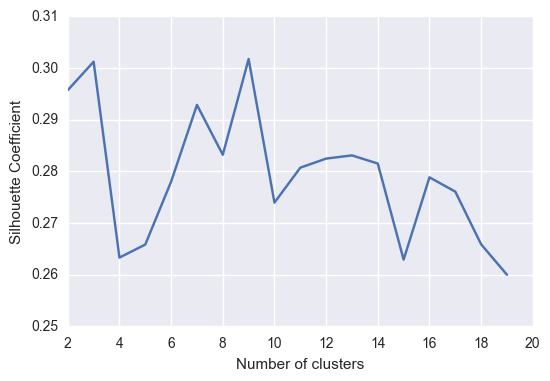

In [262]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [263]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
km = KMeans(n_clusters=9, random_state=1)
km.fit(X_scaled)
beers_full_test['cluster'] = km.labels_
beers_full_test.groupby('cluster').mean()

C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abv_x      ibu_x  originalGravity_x     ogMin  categoryId_x  \
cluster                                                                    
0         5.272070  25.958680           1.046461  1.043406      7.898712   
1         8.310967  28.387947           1.066819  1.060898      4.746356   
2         6.126230  35.631937           1.052246  1.047760      2.020675   
3         6.709658  66.556228           1.058680  1.057177      3.004941   
4         5.285596  27.944361           1.045988  1.043861      2.910031   
5        10.616207  55.631717           1.083709  1.074657      3.904762   
6         7.516667  24.166667           1.700333  1.052833      5.666667   
7         6.678391  30.873025           1.047784  1.037283     10.194601   
8         9.137121  97.128046           1.076262  1.073730      3.034819   

          styleId_x    srmId_x  brewery_established  loc_country_code  \
cluster                                                                 
0         97.118155   7.043422          1999.680292        799.647581   
1         59.927536  13.615685          1995.631720        799.023768   
2         28.947014  34.523609          2004.383808        807.924695   
3         30.378470  10.750632          2003.986101        810.759963   
4         31.316562  10.897447          2002.629842        803.587529   
5         52.351992  34.895068          2001.406023        812.246914   
6         67.333333  10.833333          2011.000000        746.000000   
7        123.363750  33.455847          2001.577857        803.599499   
8         32.655076  11.336635          2003.945967        814.570334   

         hop_alphaacid  hop_betaacid  hop_caryophyllene  hop_myrcene  \
cluster                                                                
0            13.315223      4.732244           8.925355    45.655381   
1            12.842269      4.740995           9.466820    43.502106   
2            13.081906      4.802656           9.170398    45.274375   
3            14.794870      4.848372           8.000402    51.055141   
4            13.343715      4.885953           8.638408    47.151699   
5            14.077308      4.915219           9.699336    45.492926   
6                  NaN           NaN                NaN          NaN   
7            13.082857      4.742503           9.273890    44.485284   
8            15.418219      4.811919           7.970249    51.796148   

         hop_humulene  hop_cohumulone  hop_geraniol  hop_totaloil  
cluster                                                            
0           20.462725       29.233130      0.488977      2.049839  
1           22.540594       29.240822      0.441679      1.963023  
2           20.850564       29.215765      0.475699      2.022365  
3           15.011907       28.856692      0.612436      2.344042  
4           19.249656       29.289255      0.512994      2.097399  
5           19.644265       29.950265      0.471298      2.202953  
6                 NaN             NaN           NaN           NaN  
7           21.479407       29.321462      0.478292      2.016889  
8           13.938070       29.200571      0.634711      2.454313

In [546]:
cluster_data_k9_all_std_mean = {}
for n in range(0,9):
    cluster_data_k9_all['cluster'+str(n)] ={'ABV': (beer_train2.groupby('cluster').std().loc[n,'abv']/beer_train2.groupby('cluster').mean().loc[n,'abv']),
                                     'IBU': (beer_train2.groupby('cluster').std().loc[n,'ibu']/beer_train2.groupby('cluster').mean().loc[n,'ibu']),
                                     'originalGravity': (beer_train2.groupby('cluster').std().loc[n,'originalGravity']/beer_train2.groupby('cluster').mean().loc[n,'originalGravity']),
                                     'srmID': (beer_train2.groupby('cluster').std().loc[n,'srmId']/beer_train2.groupby('cluster').mean().loc[n,'srmId']),
                                     'hop_alphaacid': (beer_train2.groupby('cluster').std().loc[n,'hop_alphaacid']/beer_train2.groupby('cluster').mean().loc[n,'hop_alphaacid']),
                                     'hop_betaacid': (beer_train2.groupby('cluster').std().loc[n,'hop_betaacid']/beer_train2.groupby('cluster').mean().loc[n,'hop_betaacid']),
                                     'hop_caryophyllene': (beer_train2.groupby('cluster').std().loc[n,'hop_caryophyllene']/beer_train2.groupby('cluster').mean().loc[n,'hop_caryophyllene']),
                                     'hop_myrcene': (beer_train2.groupby('cluster').std().loc[n,'hop_myrcene']/beer_train2.groupby('cluster').mean().loc[n,'hop_myrcene']),
                                     'hop_humulene': (beer_train2.groupby('cluster').std().loc[n,'hop_humulene']/beer_train2.groupby('cluster').mean().loc[n,'hop_humulene']),
                                     'hop_cohumulone': (beer_train2.groupby('cluster').std().loc[n,'hop_cohumulone']/beer_train2.groupby('cluster').mean().loc[n,'hop_cohumulone']),
                                     'hop_geraniol': (beer_train2.groupby('cluster').std().loc[n,'hop_geraniol']/beer_train2.groupby('cluster').mean().loc[n,'hop_geraniol']),
                                     'hop_totaloil': (beer_train2.groupby('cluster').std().loc[n,'hop_totaloil']/beer_train2.groupby('cluster').mean().loc[n,'hop_totaloil'])
                                     }

In [547]:
cluster_data_k9_all

{'cluster0': {'ABV': 0.20749555696172259,
  'IBU': 0.49120111962294805,
  'hop_alphaacid': 0.36100255838242129,
  'hop_betaacid': 0.11696970277248261,
  'hop_caryophyllene': 0.1378102945240387,
  'hop_cohumulone': 0.095786545043579155,
  'hop_geraniol': 0.50777441167465864,
  'hop_humulene': 0.18511962359861783,
  'hop_myrcene': 0.13535597037394767,
  'hop_totaloil': 0.24553993283004463,
  'originalGravity': 0.010641624235873908,
  'srmID': 0.68847731102931153},
 'cluster1': {'ABV': 0.15665271551277815,
  'IBU': 0.42365033696245352,
  'hop_alphaacid': 0.14927330213793402,
  'hop_betaacid': 0.098845572962989195,
  'hop_caryophyllene': 0.17367915602086467,
  'hop_cohumulone': 0.090122921907155901,
  'hop_geraniol': 0.41511956906028863,
  'hop_humulene': 0.21192709552527067,
  'hop_myrcene': 0.086966660731485915,
  'hop_totaloil': 0.17588254155912197,
  'originalGravity': 0.008885117152372354,
  'srmID': 0.57102623875000225},
 'cluster2': {'ABV': 0.17631249701581631,
  'IBU': 0.4679326178

In [536]:
X2 = beer_train2[['ibu',
                  'abv',
                  'originalGravity',
                  'styleId',
                  'srmId',
                  #'hop_alphaacid',
                  #'hop_betaacid',
                  #'hop_caryophyllene',
                  #'hop_myrcene',
                  #'hop_humulene',
                  #'hop_cohumulone',
                  #'hop_geraniol',
                  #'hop_totaloil'
                 ]]

In [541]:
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X2_scaled)
    scores.append(metrics.silhouette_score(X2_scaled, km.labels_))


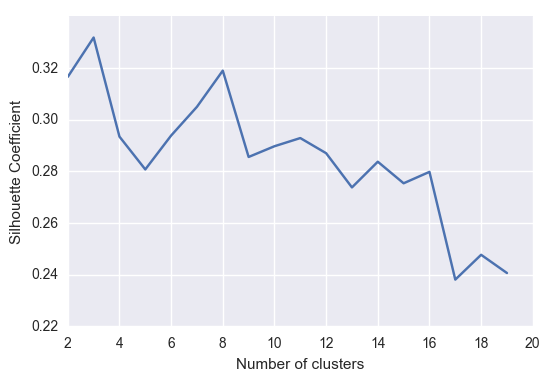

In [542]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [548]:
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)
km = KMeans(n_clusters=8, random_state=1)
km.fit(X2_scaled)
beer_train2['cluster'] = km.labels_
beer_train2.groupby('cluster').mean()

C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abv        ibu  originalGravity  categoryId     styleId  \
cluster                                                                  
0         7.727750  30.012876         1.065089    5.270386   68.027182   
1         8.993059  89.383562         1.076132    3.031133   32.222914   
2         6.747924  67.388571         1.059074    2.979429   29.924000   
3         5.208341  28.160570         1.045744    7.769374   95.115933   
4        10.485969  54.653061         1.086383    3.586006   47.615160   
5         6.175693  39.570605         1.051907    2.100865   29.603746   
6         5.313249  31.180180         1.045926    2.832105   28.973382   
7         6.682465  35.409091         1.047118   10.152273  122.147727   

             srmId  duplicate  brewery_established  loc_country_code  \
cluster                                                                
0        12.385753   0.121602          1991.091954        796.244957   
1        10.999921   0.090909          2002.828652        821.092965   
2        10.663775   0.101714          2003.574111        808.512406   
3         7.024103   0.176689          1997.802678        802.745636   
4        31.475762   0.139942          1999.470769        821.270588   
5        34.126677   0.165706          2002.230769        806.484104   
6        10.850261   0.156020          2002.172079        796.829550   
7        34.683151   0.154545          1996.570312        803.303944   

         hop_alphaacid  hop_betaacid  hop_caryophyllene  hop_myrcene  \
cluster                                                                
0            12.931559      4.762450           9.312305    43.990021   
1            15.301287      4.816107           7.981227    51.581090   
2            14.810304      4.845940           8.012964    51.052304   
3            13.402790      4.729570           8.899359    45.886751   
4            13.885083      4.895828           9.836808    44.967031   
5            13.148005      4.812715           9.122290    45.495389   
6            13.391518      4.880096           8.589971    47.364818   
7            13.097193      4.767349           9.299183    44.493019   

         hop_humulene  hop_cohumulone  hop_geraniol  hop_totaloil  
cluster                                                            
0           22.042900       29.217254      0.448052      1.979097  
1           14.130554       29.152666      0.628849      2.436218  
2           15.009238       28.906039      0.613411      2.349848  
3           20.263598       29.286717      0.495803      2.067379  
4           20.294072       29.890938      0.456057      2.157787  
5           20.625954       29.280704      0.482040      2.036869  
6           19.013887       29.247076      0.519132      2.107884  
7           21.415506       29.465268      0.473423      2.022883

In [549]:
cluster_data_k8_core_std_mean = {}
for n in range(0,8):
    cluster_data_k8_core['cluster'+str(n)] ={'ABV': (beer_train2.groupby('cluster').std().loc[n,'abv']/beer_train2.groupby('cluster').mean().loc[n,'abv']),
                                     'IBU': (beer_train2.groupby('cluster').std().loc[n,'ibu']/beer_train2.groupby('cluster').mean().loc[n,'ibu']),
                                     'originalGravity': (beer_train2.groupby('cluster').std().loc[n,'originalGravity']/beer_train2.groupby('cluster').mean().loc[n,'originalGravity']),
                                     'srmID': (beer_train2.groupby('cluster').std().loc[n,'srmId']/beer_train2.groupby('cluster').mean().loc[n,'srmId']),
                                     'hop_alphaacid': (beer_train2.groupby('cluster').std().loc[n,'hop_alphaacid']/beer_train2.groupby('cluster').mean().loc[n,'hop_alphaacid']),
                                     'hop_betaacid': (beer_train2.groupby('cluster').std().loc[n,'hop_betaacid']/beer_train2.groupby('cluster').mean().loc[n,'hop_betaacid']),
                                     'hop_caryophyllene': (beer_train2.groupby('cluster').std().loc[n,'hop_caryophyllene']/beer_train2.groupby('cluster').mean().loc[n,'hop_caryophyllene']),
                                     'hop_myrcene': (beer_train2.groupby('cluster').std().loc[n,'hop_myrcene']/beer_train2.groupby('cluster').mean().loc[n,'hop_myrcene']),
                                     'hop_humulene': (beer_train2.groupby('cluster').std().loc[n,'hop_humulene']/beer_train2.groupby('cluster').mean().loc[n,'hop_humulene']),
                                     'hop_cohumulone': (beer_train2.groupby('cluster').std().loc[n,'hop_cohumulone']/beer_train2.groupby('cluster').mean().loc[n,'hop_cohumulone']),
                                     'hop_geraniol': (beer_train2.groupby('cluster').std().loc[n,'hop_geraniol']/beer_train2.groupby('cluster').mean().loc[n,'hop_geraniol']),
                                     'hop_totaloil': (beer_train2.groupby('cluster').std().loc[n,'hop_totaloil']/beer_train2.groupby('cluster').mean().loc[n,'hop_totaloil'])
                                     }

In [550]:
cluster_data_k8_core

{'cluster0': {'ABV': 0.15276354060923256,
  'IBU': 0.40137854100010267,
  'hop_alphaacid': 0.34708074429073205,
  'hop_betaacid': 0.16459676921279068,
  'hop_caryophyllene': 0.27100913625881773,
  'hop_cohumulone': 0.099246922853445788,
  'hop_geraniol': 0.72599973103908455,
  'hop_humulene': 0.56781143068781914,
  'hop_myrcene': 0.29072380315572638,
  'hop_totaloil': 0.42475533169516705,
  'originalGravity': 0.0088132705848685232,
  'srmID': 0.5289511144915775},
 'cluster1': {'ABV': 0.10872929052790045,
  'IBU': 0.16473932707044986,
  'hop_alphaacid': 0.17924969102504415,
  'hop_betaacid': 0.13355596868235342,
  'hop_caryophyllene': 0.19318111956501419,
  'hop_cohumulone': 0.10684658597707918,
  'hop_geraniol': 0.37528493917460731,
  'hop_humulene': 0.4414046699538734,
  'hop_myrcene': 0.14314961271024074,
  'hop_totaloil': 0.21659425186528788,
  'originalGravity': 0.006933630627443314,
  'srmID': 0.33027438810385129},
 'cluster2': {'ABV': 0.10246512923439788,
  'IBU': 0.1903992127218

In [551]:
cluster = pd.DataFrame(cluster_data_k8_core)

In [552]:
cluster.head(10)

cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  \
ABV                0.152764  0.108729  0.102465  0.133647  0.262132  0.175935   
IBU                0.401379  0.164739  0.190399  0.497350  0.385638  0.461856   
hop_alphaacid      0.347081  0.179250  0.199756  0.319545  0.296004  0.325490   
hop_betaacid       0.164597  0.133556  0.144677  0.143980  0.183243  0.195975   
hop_caryophyllene  0.271009  0.193181  0.191520  0.257835  0.290190  0.255781   
hop_cohumulone     0.099247  0.106847  0.108007  0.094942  0.125374  0.101298   
hop_geraniol       0.726000  0.375285  0.402677  0.619739  0.740703  0.636384   
hop_humulene       0.567811  0.441405  0.456845  0.585891  0.540567  0.556287   
hop_myrcene        0.290724  0.143150  0.156013  0.267176  0.258522  0.258366   
hop_totaloil       0.424755  0.216594  0.233151  0.389444  0.368927  0.390061   

                   cluster6  cluster7  
ABV                0.134606  0.259014  
IBU                0.396797  0.586633  
hop_alphaacid      0.300686  0.349077  
hop_betaacid       0.177171  0.169609  
hop_caryophyllene  0.246115  0.267808  
hop_cohumulone     0.099234  0.099808  
hop_geraniol       0.569010  0.685025  
hop_humulene       0.565644  0.581100  
hop_myrcene        0.237503  0.285435  
hop_totaloil       0.347523  0.422536

In [553]:
cluster_all = pd.DataFrame(cluster_data_k9_all)
cluster_all.head(10)

cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  \
ABV                0.207496  0.156653  0.176312  0.190320  0.248553  0.161766   
IBU                0.491201  0.423650  0.467933  0.269584  0.553754  0.443513   
hop_alphaacid      0.361003  0.149273  0.150367  0.066418  0.091414  0.052801   
hop_betaacid       0.116970  0.098846  0.125390  0.068688  0.135549  0.038336   
hop_caryophyllene  0.137810  0.173679  0.123469  0.094391  0.051014  0.055465   
hop_cohumulone     0.095787  0.090123  0.071809  0.040176  0.053464  0.049047   
hop_geraniol       0.507774  0.415120  0.390743  0.202247  2.818592  0.139396   
hop_humulene       0.185120  0.211927  0.166573  0.183999  0.092037  0.129553   
hop_myrcene        0.135356  0.086967  0.102192  0.051210  0.118748  0.041404   
hop_totaloil       0.245540  0.175883  0.153886  0.084406  0.192669  0.072391   

                   cluster6  cluster7  cluster8  
ABV                0.234261  0.273359  0.177571  
IBU                0.471648  0.465095  0.265813  
hop_alphaacid      0.108783  0.260061  0.112225  
hop_betaacid       0.094405  0.180296  0.135326  
hop_caryophyllene  0.126781  0.206676  0.146840  
hop_cohumulone     0.065377  0.125473  0.092565  
hop_geraniol       0.229316  0.852483  0.336324  
hop_humulene       0.289324  0.305053  0.209642  
hop_myrcene        0.089092  0.186110  0.118948  
hop_totaloil       0.133654  0.348531  0.116528

In [ ]:
X2 = beer_train2[['ibu',
                  'abv',
                  'originalGravity',
                  'styleId',
                  'srmId',
                  #'hop_alphaacid',
                  #'hop_betaacid',
                  #'hop_caryophyllene',
                  #'hop_myrcene',
                  #'hop_humulene',
                  #'hop_cohumulone',
                  #'hop_geraniol',
                  #'hop_totaloil'
                 ]]

In [138]:
from sklearn.cluster import DBSCAN



In [144]:
db = DBSCAN(eps=3, min_samples=3)
db.fit(X_scaled)
beer_train2['cluster_db'] = db.labels_
beer_train2.groupby('cluster_db').mean()

C:\Users\antho\Anaconda2\envs\data28\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1        abv        ibu  \
cluster_db                                                                  
-1          7232.200000   7232.200000   7232.200000  21.735000  27.900000   
 0          9781.798064   9781.798064   9781.798064   6.482687  40.325976   

            originalGravity  categoryId    styleId      srmId  duplicate  \
cluster_db                                                                 
-1                 1.412847    5.600000  66.000000  16.859082   0.000000   
 0                 1.054472    4.572314  54.391324  16.053118   0.131517   

            loc_country_code    cluster  cluster2  cluster3  
cluster_db                                                   
-1                838.600000  11.500000  9.800000  6.400000  
 0                803.151546   9.952935  9.807436  2.691181

In [146]:
eps_range =(.1, .2, .5, 1, 1.5, 2, 2.5, 3)
scores = []
for k in eps_range:
    db = DBSCAN(eps=k, min_samples=3)
    db.fit(X_scaled)
    if len(set(db.labels_)) > 1:
        scores.append(metrics.silhouette_score(X_scaled, db.labels_))
    else:
        scores.append(0)

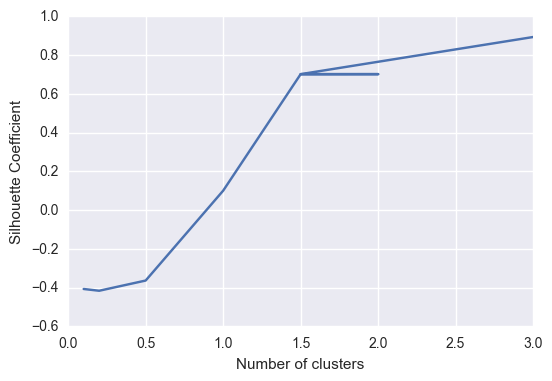

In [147]:
plt.plot(eps_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [155]:
from collections import Counter
db = DBSCAN(eps=1.5, min_samples=3)
db.fit(X_scaled)
Counter(db.labels_)

Counter({-1: 36, 0: 19493, 1: 3, 2: 4})

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [12]:
beer_train.shape

(19553, 33)

In [15]:
for n_components in (5, 10, 20, 27):
    vect = TfidfVectorizer(stop_words='english')
    svd = TruncatedSVD(n_components=n_components)
    lsa = make_pipeline(vect, svd, Normalizer(copy=False))

    X_lsa = lsa.fit_transform(beer_train)
    km = KMeans(n_clusters=9, random_state=1)

    print("Clustering sparse data with %s components" % n_components)
    km.fit(X_lsa)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X_lsa, km.labels_))


Clustering sparse data with 5 components
Silhouette Coefficient: 0.459
Clustering sparse data with 10 components
Silhouette Coefficient: 0.258
Clustering sparse data with 20 components
Silhouette Coefficient: 0.205
Clustering sparse data with 27 components
Silhouette Coefficient: 0.296


In [16]:
k_range = range(2, 20)
scores = []
for k in k_range:
    vect = TfidfVectorizer(stop_words='english')
    svd = TruncatedSVD(n_components=27)
    lsa = make_pipeline(vect, svd, Normalizer(copy=False))
    X_lsa = lsa.fit_transform(beer_train)
    km = KMeans(n_clusters=k)
    km.fit(X_lsa)
    scores.append(metrics.silhouette_score(X_lsa, km.labels_))

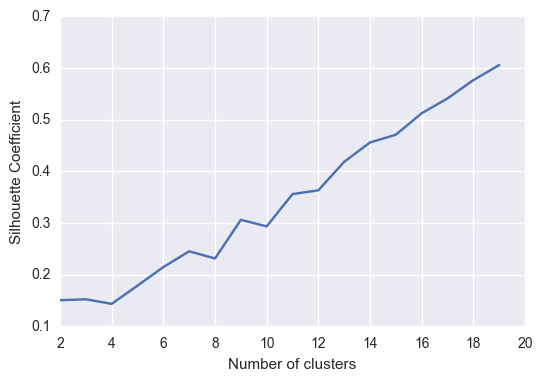

In [17]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [18]:
vect = TfidfVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=5)
lsa = make_pipeline(vect, svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(beer_train)
km = KMeans(n_clusters=9)
km.fit(X_lsa)
print km.labels_
beer_train['cluster'] = km.labels_
beer_train.groupby('cluster').mean()

[2 2 2 2 2 4 0 7 0 8 1 3 1 0 3 1 4 0 7 3 5 8 4 6 6 3 6 6 1 5 6 4 5]


ValueError: Length of values does not match length of index